In [1]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt 
import geopandas as gpd
import osmnx as ox
import itertools as it
import traffix as tx
%matplotlib inline

# Preprocessing

## 1. Graph from OSM (Kota Yogyakarta, Indonesia)

In [2]:
# Street networks from a geocode location.
G = ox.graph.graph_from_place("Kota Yogyakarta, Indonesia",network_type='drive', simplify=True, custom_filter='["highway"~"primary|trunk|secondary|tertiary"]')

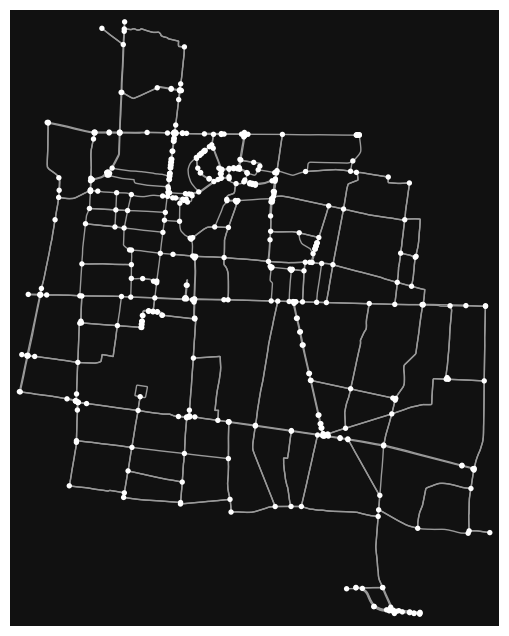

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# Visualisation
ox.plot_graph(G)

## Origin Destination (OD)'s Nodes Location

### Inputting OD's Geometry

(427358.0889348225, 434946.5295682836, -867085.2089826264, -858130.7770321547)

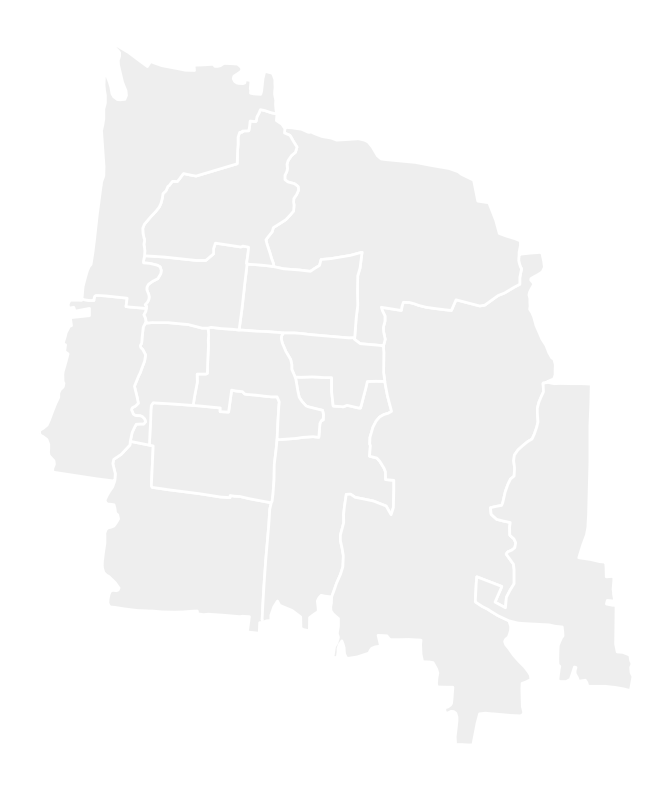

In [4]:
#Pakualaman is not defined in OpenStreetMap, merging the geometry that constitute Pakualaman.
pakualaman = ["Gunung ketur, Kota Yogyakarta, Indonesia","Bausasran, Kota Yogyakarta, Indonesia",
              "Pakualaman, Kota Yogyakarta, Indonesia", 
              "Batas Wilayah RW 02 Kelurahan Gunungketur, Kota Yogyakarta, Indonesia"]
pakualaman = ox.geocode_to_gdf(pakualaman)
pakualaman = pakualaman.dissolve()
pakualaman = pakualaman.replace("Gunung ketur, Yogyakarta, Special Region of Yogyakarta, Indonesia",
                                "Pakualaman, Yogyakarta, Special Region of Yogyakarta, Indonesia")

#Other location used as inner OD.
places = ["Mantrijeron, Kota Yogyakarta, Indonesia","Kraton, Kota Yogyakarta, Indonesia",
          "Mergangsan, Kota Yogyakarta, Indonesia","Umbulharjo, Kota Yogyakarta, Indonesia",
          "Kotagede, Kota Yogyakarta, Indonesia","Gondokusuman, Kota Yogyakarta, Indonesia",
          "Danurejan, Kota Yogyakarta, Indonesia", "Gondomanan, Kota Yogyakarta, Indonesia",
          "Ngampilan, Kota Yogyakarta, Indonesia", "Wirobrajan, Kota Yogyakarta, Indonesia",
          "Gedongtengen, Kota Yogyakarta, Indonesia", "Jetis, Kota Yogyakarta, Indonesia",
          "Tegalrejo, Kota Yogyakarta, Indonesia"]

#Polygon of the places.
places = ox.geocode_to_gdf(places)

#Concatenating pakualaman to the data.
places = pd.concat([places.iloc[:7], pakualaman, places.iloc[7:]], ignore_index=True)

places = ox.project_gdf(places)
fig, ax = plt.subplots(figsize=(20, 10))
places.plot(ax=ax, facecolor="#eeeeee", edgecolor="white", alpha=1, linewidth=2)
ax.axis('off')

(311271.23004651885, 531461.0512117816, -914449.9946570757, -748115.8121198618)

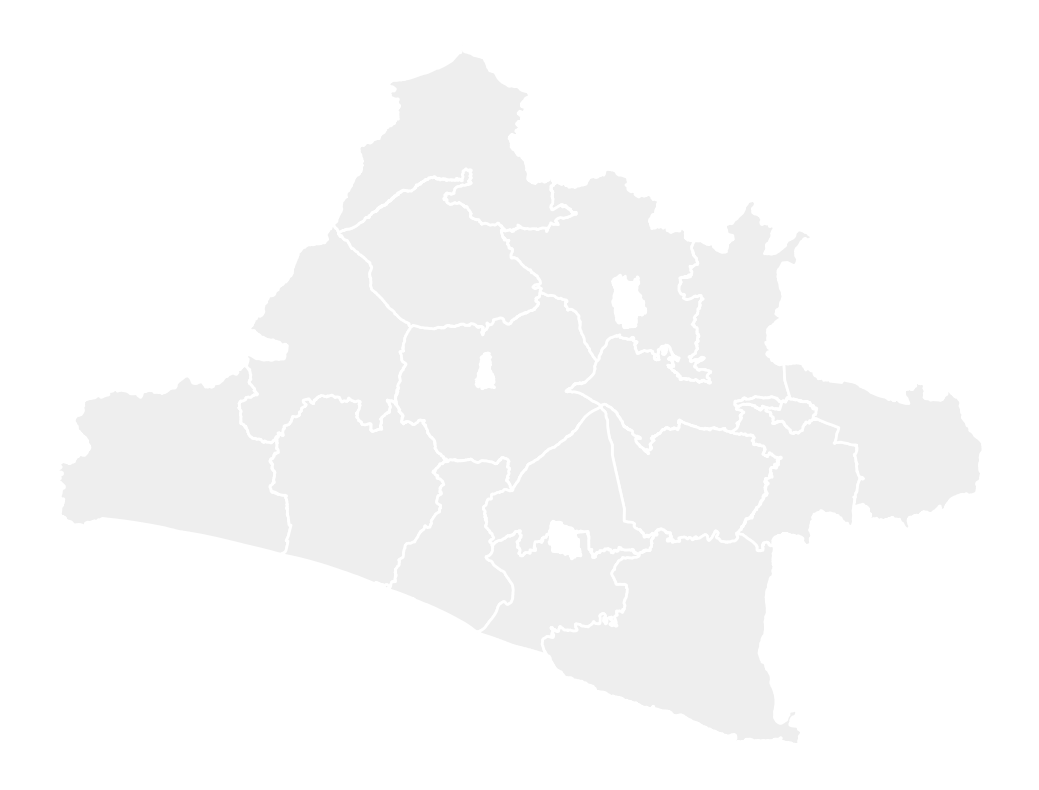

In [5]:
#Outer OD
places_outer = ["Kebumen, Jawa Tengah, Indonesia","Purworejo, Jawa Tengah, Indonesia",
          "Wonosobo, Jawa Tengah, Indonesia","Magelang, Jawa Tengah, Indonesia",
          "Boyolali, Jawa Tengah, Indonesia","Klaten, Jawa Tengah, Indonesia",
          "Sukoharjo, Jawa Tengah, Indonesia","Karanganyar, Jawa Tengah, Indonesia",
          "Semarang, Jawa Tengah, Indonesia", "Temanggung, Jawa Tengah, Indonesia",
          "Kendal, Jawa Tengah, Indonesia",
          "Surakarta, Jawa Tengah, Indonesia","Kulon Progo, Daerah Istimewa Yogyakarta, Indonesia",
          "Bantul, Daerah Istimewa Yogyakarta, Indonesia",
          "Kabupaten Gunung Kidul, Daerah Istimewa Yogyakarta, Indonesia",
          "Sleman Regency, Daerah Istimewa Yogyakarta, Indonesia"]

places_outer = ox.geocode_to_gdf(places_outer)

places_outer = ox.project_gdf(places_outer)
fig, ax = plt.subplots(figsize=(20, 10))
places_outer.plot(ax=ax, facecolor="#eeeeee", edgecolor="white", alpha=1, linewidth=2)
ax.axis('off')

In [6]:
G = ox.graph.graph_from_place("Kota Yogyakarta, Indonesia",network_type='drive', simplify=True, custom_filter='["highway"~"primary|trunk|secondary|tertiary"]')
gdfs = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True, fill_edge_geometry=True)
#display(gdfs)
#Convert to planar
##gdfs = ox.projection.project_gdf(gdfs,to_crs='EPSG:23879')
gdfs = ox.projection.project_gdf(gdfs,to_crs='+proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs')
#print(gdfs.crs)

In [7]:
G.graph["crs"]

'epsg:4326'

In [8]:
print(gdfs.crs)

+proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


Text(0.5, 1.0, 'OD nodes in Kota Yogyakarta')

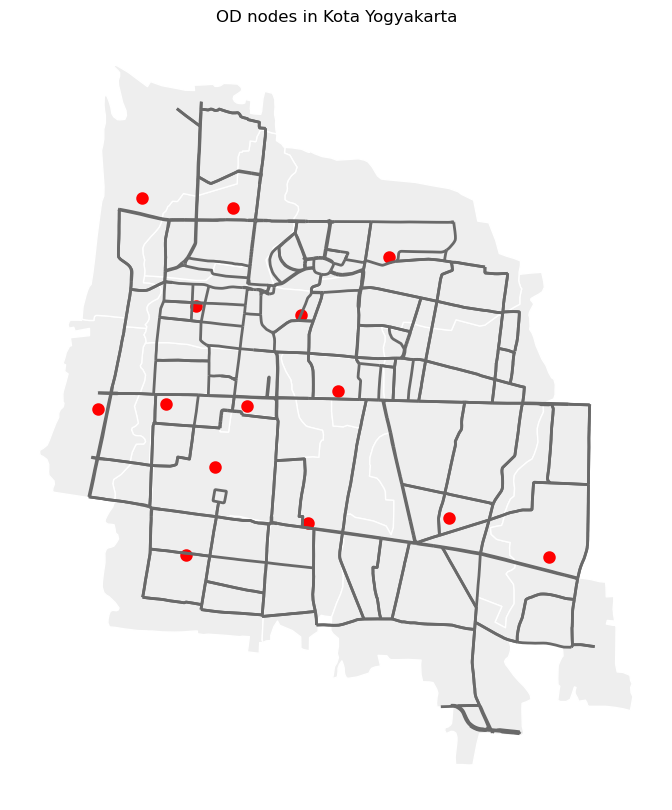

In [17]:
#It is assumed that OD nodes are in the 
# Centre Point of inner OD's polygon.
node_OD = places['geometry'].representative_point()
fig, ax = plt.subplots(figsize=(20, 10))
places.plot(ax=ax, facecolor="#eeeeee", edgecolor="white", alpha=1, linewidth=1)
node_OD.plot(ax=ax, linewidth=3, alpha=1, color='red')
gdfs.plot(ax=ax, linewidth=2, color="dimgrey", alpha=1)
ax.axis("off")
ax.set_title("OD nodes in Kota Yogyakarta")

Text(0.5, 1.0, 'Titik OD di Luar Yogyakarta')

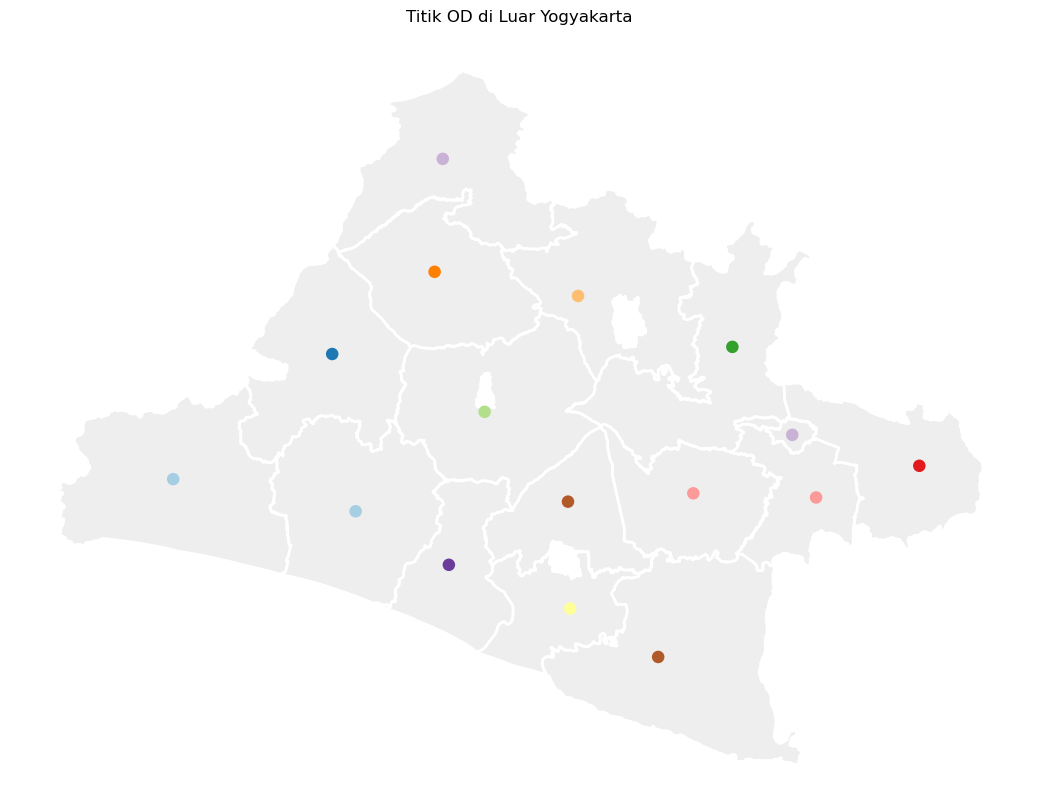

In [18]:
#For outer OD
node_OD_outer = places_outer['geometry'].representative_point()
fig, ax = plt.subplots(figsize=(20, 10))
places_outer.plot(ax=ax, facecolor="#eeeeee", edgecolor="white", alpha=1, linewidth=2)
node_OD_outer.plot(ax=ax, linewidth=3, alpha=1, cmap="Paired")
ax.axis("off")
ax.set_title("Titik OD di Luar Yogyakarta")

### Nearest Nodes of each OD

#### Inner OD

In [19]:
#Finding langitude and latitude from OD's centre point.
X = node_OD.x.values
Y = node_OD.y.values

#Nearest Nodes.
nodes_inner = pd.Series(ox.nearest_nodes(G, X, Y))

#### Outer OD

In [20]:
#Finding langitude and latitude from OD's centre point.
X = node_OD_outer.x.values
Y = node_OD_outer.y.values

#Nearest Nodes.
nodes_outer = pd.Series(ox.nearest_nodes(G, X, Y))

In [42]:
#Concatenate inner and outer ODs
nodes_od = pd.concat([nodes_inner, nodes_outer], ignore_index=True)

0     10232167991
1     10232167991
2      1625428085
3      5606220000
4     10232167991
5      2325131657
6      5610878579
7      1660354503
8     10232167991
9     10232167991
10     5634358070
11     5610878579
12     5606220000
13     5606220000
14     1625428085
15     1625428085
16     7284040691
17     5606220000
18     6820465609
19     5606220000
20     1625428085
21    10232167991
22     1625428085
23     5606220000
24     6820465609
25      270392740
26      270392740
27     6820465609
28     1661691774
29     5606220000
dtype: int64

## Getting Flow From OD Matrices

In [23]:
#Tidying OD matrices
OD = pd.read_excel('OD.xlsx',sheet_name='read')
OD.columns = list(range(1,len(OD.index)+1))

### Flow function

In [25]:
%%time
#using numpy structured array
flow1 = np.fromiter(tx.Flow_from_OD(pd.read_excel('OD.xlsx',sheet_name='read')), 
                   dtype=[('origin','int64'),('dests','int64'),('flow','int64')])
flow1 = flow1['flow']

## Speed, Travel Times, Lane, Width and Capacity Imputation.

### Speed
The `ox.add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [28]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

### Initial Travel Times

In [29]:
# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

### Lanes

In [31]:
G = tx.add_edge_lanes(G)

### Width

In [32]:
G = tx.add_edge_width(G)

### Capacity
Imputing capacity value based on modification of 'ox.add_edge_travel_times()'.
The capacity is based on lane width and lane numbers.
The value used is based on Indonesia's Highway Capacity Manual.
If there is no lane width nor lane numbers, the capacity of the edges is assumed 1650,
the capacity for 1 lane of 3.5m width.

In [33]:
G = tx.add_edge_capacity(G)

## Flatten OSMid

During simplification of OpenStreetMap data we commonly found multiple values of osmID and name in a link, therefore we need to flatten this values into a singular values.

In [34]:
#Flatten osmid
G = tx.flatten_osmid(G)
#Convert networkX graph into GeoDataFrame.
list_jalan = ox.graph_to_gdfs(ox.project_graph(G), nodes=False)
#Summary of the number of highway based on the highway type.
list_jalan.groupby("highway",dropna=False)[["length", "speed_kph", "travel_time","lanes","width"]].size()
list_jalan

osmid  oneway  lanes   
u           v           key                              
262855957   7698514133  0     824465136    True      2  \
            7305115594  0     933729436    True      2   
7698514133  269401983   0     289505394    True      3   
7305115594  7698514133  0     824465135    True      2   
            7305115644  0     824492966    True      2   
...                                 ...     ...    ...   
10278690374 10278690372 0     590301378    True      2   
10278690373 5636328405  0    1096212684    True      2   
            10278690374 0    1123960536   False      1   
10278525281 10278525280 0    1123951620   False      1   
            10278525279 0    1096212684    True      2   

                                                name       highway reversed   
u           v           key                                                   
262855957   7698514133  0       Jalan Urip Sumoharjo       primary    False  \
            7305115594  0              Jalan Affandi       primary    False   
7698514133  269401983   0       Jalan Urip Sumoharjo       primary    False   
7305115594  7698514133  0       Jalan Urip Sumoharjo       primary    False   
            7305115644  0    Jalan Laksda Adisucipto       primary    False   
...                                              ...           ...      ...   
10278690374 10278690372 0          Jalan Margo Utomo      tertiary    False   
10278690373 5636328405  0          Jalan Margo Utomo       primary    False   
            10278690374 0                        NaN  primary_link     True   
10278525281 10278525280 0                        NaN  primary_link    False   
            10278525279 0          Jalan Margo Utomo       primary    False   

                              length  speed_kph  travel_time width  capacity   
u           v           key                                                    
262855957   7698514133  0      8.843       40.0          0.8   3.5      3300  \
            7305115594  0      7.396       40.0          0.7     5      3300   
7698514133  269401983   0    921.751       40.0         83.0   3.5      4950   
7305115594  7698514133  0      9.463       40.0          0.9   3.5      3300   
            7305115644  0      8.794       40.0          0.8   3.5      3300   
...                              ...        ...          ...   ...       ...   
10278690374 10278690372 0     32.939       36.7          3.2     6      3300   
10278690373 5636328405  0     33.106       40.0          3.0     6      3300   
            10278690374 0      7.908       40.0          0.7   3.5      1650   
10278525281 10278525280 0      8.824       40.0          0.8   3.5      1650   
            10278525279 0     36.481       40.0          3.3     6      3300   

                                                                      geometry   
u           v           key                                                      
262855957   7698514133  0    LINESTRING (432488.390 -860369.437, 432480.094...  \
            7305115594  0    LINESTRING (432488.390 -860369.437, 432488.523...   
7698514133  269401983   0    LINESTRING (432480.094 -860366.376, 432464.713...   
7305115594  7698514133  0    LINESTRING (432488.523 -860362.085, 432480.094...   
            7305115644  0    LINESTRING (432488.523 -860362.085, 432497.321...   
...                                                                        ...   
10278690374 10278690372 0    LINESTRING (430158.802 -860743.543, 430158.509...   
10278690373 5636328405  0    LINESTRING (430166.654 -860744.526, 430162.656...   
            10278690374 0    LINESTRING (430166.654 -860744.526, 430158.802...   
10278525281 10278525280 0    LINESTRING (430175.221 -860670.783, 430166.465...   
            10278525279 0    LINESTRING (430175.221 -860670.783, 430172.177...   

                            junction bridge maxspeed tunnel access  ref  
u           v           key                                          

# Process Algorithm

# User Equilibrium / Convex Combinations Algorithm

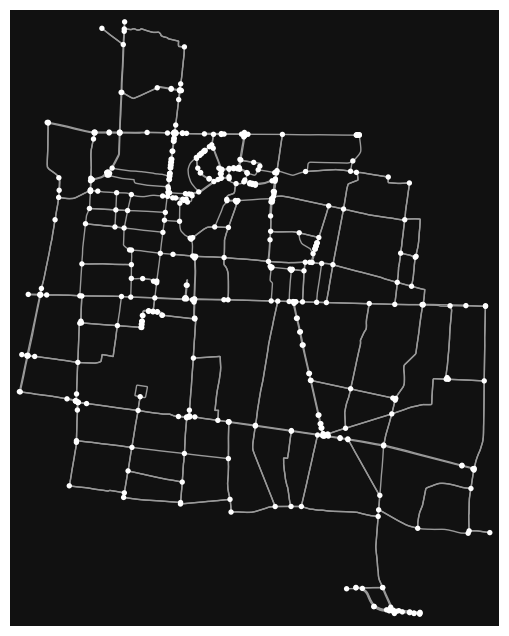

In [36]:
#Network street data is very sensitive,
#and are therefore redefined here.
G = ox.graph.graph_from_place("Kota Yogyakarta, Indonesia",network_type='drive', simplify=True, custom_filter='["highway"~"primary|trunk|secondary|tertiary"]')
ox.plot_graph(G)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = tx.add_edge_lanes(G)
G = tx.add_edge_width(G)
G = tx.add_edge_capacity(G)
G = tx.flatten_osmid(G)

In [46]:
def CCA(G, nodes_OD, flow, number_of_iteration=10000, alpha=0.15, beta=4):
    #Initialize initial time_travel column based on travel time column 
    #from ox.add_edge_travel_times
    G = tx.add_edge_initial_travel_time(G)
    
    # Initialize flow from OD Matrices, do shortest path
    # and Assign flow to all links.
    G = tx.OD_shortest_path(G, nodes_OD, flow, flow_type='flow')
    
    condition = True
    n = 0
    while condition == True:

        #Update travel time
        G = tx.update_travel_time_lpr(G, alpha, beta)

        # Initialize flow from OD Matrices, do shortest path
        # and calculate auxiliary flow.
        G = tx.OD_shortest_path(G, nodes_OD, flow, flow_type='auxflow')

        # line search using bisection method
        alpha = tx.bisection(G, alpha=alpha, beta=beta)
        if n > number_of_iteration:
            condition = False
        alpha_old = alpha
        #updating mainflow based on optimal move size and auxflow
        G = tx.update_mainflow(G, alpha)
        n+=1
        print(n)
    return G

In [47]:
ue = CCA(G, nodes_od, flow1)

1
2


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
list_jalan = ox.graph_to_gdfs(ox.project_graph(G), nodes=False)
display(list_jalan)
display(mape(list_jalan['flow'],list_jalan['auxflow']))
list_jalan['flow'].corr(list_jalan['auxflow'])

osmid  oneway  lanes  \
u           v           key                              
262855957   7698514133  0     824465136    True      2   
            7305115594  0     933729436    True      2   
7698514133  269401983   0     289505394    True      3   
7305115594  7698514133  0     824465135    True      2   
            7305115644  0     824492966    True      2   
...                                 ...     ...    ...   
10278690374 10278690372 0     590301378    True      2   
10278690373 5636328405  0    1096212684    True      2   
            10278690374 0    1123960536   False      1   
10278525281 10278525280 0    1123951620   False      1   
            10278525279 0    1096212684    True      2   

                                                name       highway reversed  \
u           v           key                                                   
262855957   7698514133  0       Jalan Urip Sumoharjo       primary    False   
            7305115594  0              Jalan Affandi       primary    False   
7698514133  269401983   0       Jalan Urip Sumoharjo       primary    False   
7305115594  7698514133  0       Jalan Urip Sumoharjo       primary    False   
            7305115644  0    Jalan Laksda Adisucipto       primary    False   
...                                              ...           ...      ...   
10278690374 10278690372 0          Jalan Margo Utomo      tertiary    False   
10278690373 5636328405  0          Jalan Margo Utomo       primary    False   
            10278690374 0                        NaN  primary_link     True   
10278525281 10278525280 0                        NaN  primary_link    False   
            10278525279 0          Jalan Margo Utomo       primary    False   

                              length  speed_kph  travel_time width  ...  \
u           v           key                                         ...   
262855957   7698514133  0      8.843       40.0     0.829646   3.5  ...   
            7305115594  0      7.396       40.0     0.700000     5  ...   
7698514133  269401983   0    921.751       40.0    83.607562   3.5  ...   
7305115594  7698514133  0      9.463       40.0     0.900000   3.5  ...   
            7305115644  0      8.794       40.0     0.800000   3.5  ...   
...                              ...        ...          ...   ...  ...   
10278690374 10278690372 0     32.939       36.7     3.200000     6  ...   
10278690373 5636328405  0     33.106       40.0     3.000463     6  ...   
            10278690374 0      7.908       40.0     0.700000   3.5  ...   
10278525281 10278525280 0      8.824       40.0     0.800000   3.5  ...   
            10278525279 0     36.481       40.0     3.300510     6  ...   

                             initial_travel_time         flow  auxflow  \
u           v           key                                              
262855957   7698514133  0                    0.8  4256.792227     3790   
            7305115594  0                    0.7     0.000000        0   
7698514133  269401983   0                   83.0  4256.792227     3790   
7305115594  7698514133  0                    0.9     0.000000        0   
            7305115644  0                    0.8     0.000000        0   
...                                          ...          ...      ...   
10278690374 10278690372 0                    3.2     0.000000        0   
10278690373 5636328405  0                    3.0  1068.738272        0   
            10278690374 0                    0.7     0.000000        0   
10278525281 10278525280 0                    0.8     0.000000        0   
            10278525279 0                    3.3  1068.738272        0   

                                                                      geometry  \
u           v           key                                                      
262855957   7698514133  0    LINESTRING (432488.390 -860369.437, 432480.094...   
            7305115594  0    LINESTRING (432488.390 -860369.437, 4

0.809404472513593

0.7245078689431457

# 7. Validation Test

## Method 1: Scalable Quality Value Method

In [ ]:
#MGEH
def mgeh(arr_obs, arr_model):
    return np.sqrt(np.square(arr_model-arr_obs)/arr_obs)

#scaling factor
def scaling_factor(arr_obs):
    return np.ma.average(arr_obs)

#normal sqv
def n_sqv(arr_obs, arr_model, arr_corr=1):
    if type(arr_corr) is np.ndarray:
        arr_corr=arr_corr/arr_obs
    return 1/(1+np.sqrt(np.square(arr_model-arr_obs)/
            (np.ma.average(arr_obs)*arr_obs*arr_corr)))



## Method 2: Root Mean Square Error

In [ ]:
def RMSE(actual,predicted):
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
    RMSE = math.sqrt(MSE)
    return RMSE

<b>Integration needed </b>

In [ ]:
#SQV standard deviation
std_sqv=mgeh(observed,modeled)*np.sqrt(observed)
print(std_sqv)

NameError: name 'observed' is not defined

In [ ]:
#Normal standard deviation
std=np.std(observed)
print(std)

2.8722813232690143


In [ ]:
#implicit standard deviation - mgeh standard deviation
np.std(observed)-(mgeh(observed,modeled)*np.sqrt(observed))

array([2.77228132, 2.27228132, 2.67228132, 2.47228132, 2.07228132,
       1.57228132, 2.67228132, 2.77228132, 2.57228132, 2.67228132])

In [ ]:
#0+
observed_plus=observed+np.maximum(0,np.std(observed)
                      -(mgeh(observed,modeled)*np.sqrt(observed)))
print(observed)

[ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
#Margin of Error
def rSamplingErr(arr_obs,z=1.44):
    return z*np.std(arr_obs)/math.sqrt(len(arr_obs)/np.mean(arr_obs)

SyntaxError: invalid syntax (816697539.py, line 4)

In [ ]:
rSamplingErr(observed)

0.23780817326729384

In [ ]:
observed_Splus=observed_plus*(1+rSamplingErr(observed))
print(observed_Splus)

[ 4.66936065  5.28826474  7.02119618  8.01144272  8.75412763  9.37303171
 11.97242888 13.33401787 14.32426441 15.6858534 ]


In [ ]:
#compate modified n_sqv and manually calculate corrected sqv
print(n_sqv(observed, modeled,observed_Splus))

c_sqv=1/(1+np.sqrt(np.square(modeled-observed)/
            (np.ma.average(observed)*observed_Splus)))
print(c_sqv)

[0.98064899 0.89988476 0.9688193  0.94316561 0.89662553 0.8466972
 0.97594622 0.9884576  0.96730603 0.97892137]
[0.98064899 0.89988476 0.9688193  0.94316561 0.89662553 0.8466972
 0.97594622 0.9884576  0.96730603 0.97892137]
